> **Retno Puji Astuti**

> **24083010080**

> **Analisis Numerik (A)**

**Peta topogradi bukit disuatu daerah**

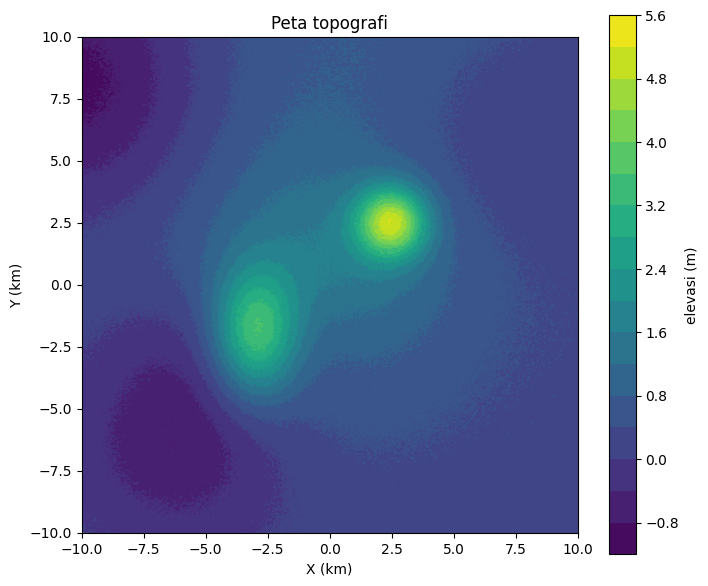

In [8]:
import numpy as np
import matplotlib.pyplot as plt

NPM=80
np.random.seed(NPM)

# grid
nx, ny = 400, 400
x = np.linspace(-10, 10, nx)
y = np.linspace(-10, 10, ny)
X, Y = np.meshgrid(x, y)

# puncak/lembah berdasarkan fungsi eksponen
# x0, y0: posisi
# sx, sy: sebaran lelehan tumpengnya
# amp   : amplitudo
def peak(x0, y0, sx, sy, amp):
    return amp * np.exp(-(((X - x0)**2) / (2*sx**2) + ((Y - y0)**2) / (2*sy**2)))

Z = peak(-3, -2, 1.2, 1.8, 3.2) + peak(2.5, 2.5, 1.0, 1.0, 4) + peak(0, 0, 3.5, 3.5, 1.2) \
    + peak(6, 6, 4, 4, -0.6)  + peak(-10, 8, 3.5, 3.5, -1.2) +  peak(-6, -6, 3, 3, -1.0) \
    + peak(-2, -2, 4, 2, -0.6)  + peak(2.5, 9.5, 6, 6, 0.75)

# exponential decay seperti global slope
Z += 0.5 * np.exp(-(np.sqrt((X/20)**2 + (Y/10)**2)))

# variasi ripple kontur (acak)
Z += 0.05 * np.random.randn(*Z.shape)

# plot
fig, ax = plt.subplots(figsize=(8, 7))
levels = 18  # number of contour levels
cf = ax.contourf(X, Y, Z, levels=levels)
cs = ax.contour(X, Y, Z, levels=levels, linewidths=0.6)
ax.clabel(cs, fmt="%.1f", fontsize=8)
ax.set_title("Peta topografi")
ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_aspect('equal', adjustable='box')
plt.colorbar(cf, ax=ax, label="elevasi (m)")

**1) Mencari titik tertinggi global mengunakan metode optimasi titik maksimum**

Titik maksimum lokal:
  x = 2.400
  y = 2.595
  Z = 5.215


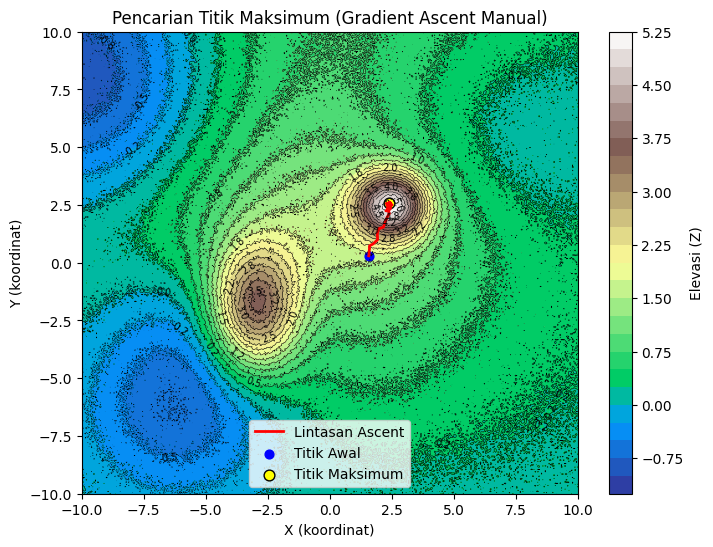

In [18]:
dx = x[1] - x[0]
dy = y[1] - y[0]

dZ_dx = np.zeros_like(Z)
dZ_dy = np.zeros_like(Z)

for i in range(1, Z.shape[0]-1):
    for j in range(1, Z.shape[1]-1):
        dZ_dx[i, j] = (Z[i, j+1] - Z[i, j-1]) / (2 * dx)
        dZ_dy[i, j] = (Z[i+1, j] - Z[i-1, j]) / (2 * dy)

# untuk tepi (forward/backward difference)
dZ_dx[:, 0]  = (Z[:, 1] - Z[:, 0]) / dx
dZ_dx[:, -1] = (Z[:, -1] - Z[:, -2]) / dx
dZ_dy[0, :]  = (Z[1, :] - Z[0, :]) / dy
dZ_dy[-1, :] = (Z[-1, :] - Z[-2, :]) / dy

# fungsi bantu ambil nilai & gradien di titik (x0, y0)
def get_value_and_grad(x0, y0):
    ix = np.searchsorted(x, x0)
    iy = np.searchsorted(y, y0)
    ix = np.clip(ix, 1, len(x)-2)
    iy = np.clip(iy, 1, len(y)-2)
    return Z[iy, ix], dZ_dx[iy, ix], dZ_dy[iy, ix]

# parameter optimasi
alpha = 0.1       # (step size)
tol = 1e-4
max_iter = 500

# titik awal acak dalam rentang data
x_pos = np.random.uniform(x[0], x[-1])
y_pos = np.random.uniform(y[0], y[-1])

# Initialize path to store the optimization steps
path = [(x_pos, y_pos)]

# Gradient Ascent
for _ in range(max_iter):
    z_val, gx, gy = get_value_and_grad(x_pos, y_pos)

    # Update posisi (naik ke arah gradien)
    x_new = x_pos + alpha * gx
    y_new = y_pos + alpha * gy

    # Pastikan tetap di dalam batas peta
    x_new = np.clip(x_new, x[0], x[-1])
    y_new = np.clip(y_new, y[0], y[-1])

    # Cek konvergensi
    if np.hypot(x_new - x_pos, y_new - y_pos) < tol:
        break

    x_pos, y_pos = x_new, y_new
    path.append((x_pos, y_pos))


# Setelah loop selesai, hitung ulang nilai Z di titik akhir
z_val, _, _ = get_value_and_grad(x_pos, y_pos)

print(f"Titik maksimum lokal:")
print(f"  x = {x_pos:.3f}")
print(f"  y = {y_pos:.3f}")
print(f"  Z = {z_val:.3f}")

# visualisasi
path = np.array(path)

fig, ax = plt.subplots(figsize=(8, 6))
levels = 30
contour = ax.contourf(X, Y, Z, levels=levels, cmap='terrain')
cs = ax.contour(X, Y, Z, levels=levels, colors='k', linewidths=0.4)
ax.clabel(cs, fmt="%.1f", fontsize=7)

ax.plot(path[:, 0], path[:, 1], 'r-', linewidth=2, label='Lintasan Ascent')
ax.scatter(path[0, 0], path[0, 1], c='blue', s=40, label='Titik Awal')
ax.scatter(path[-1, 0], path[-1, 1], c='yellow', edgecolors='k', s=60, label='Titik Maksimum')

ax.set_title("Pencarian Titik Maksimum (Gradient Ascent Manual)")
ax.set_xlabel("X (koordinat)")
ax.set_ylabel("Y (koordinat)")
ax.legend()
plt.colorbar(contour, ax=ax, label='Elevasi (Z)')
plt.show()

**Penjelasan :**

Dari visualisasi diatas dapat dikatakan telah menemukan puncak lokal dan menampilkan lintasan menuju titik maksimum lokal dan menampilkan lintasan menuju puncak permukaan. Dimulai dari tahap perhitungan untuk menentukan jarak antar titik grid (turunan numerik), kemudian dilanjutkan dengan menghitung gradien central difference untuk bagian tengah dan forward/backward untuk bagian tepi.

Setelah gradien diperoleh, algoritma mencari titik awal secara acak di dalam rentang data sebagai posisi awal pencarian puncak. Posisi ini kemudian diperbarui secara bertahap dengan bergerak ke arah gradien terbesar, yaitu arah kenaikan elevasi paling curam di permukaan. Setiap perpindahan posisi disimpan dalam variabel path, sehingga membentuk lintasan yang menggambarkan pergerakan titik selama proses menuju maksimum lokal.

Secara keseluruhan, hasil visualisasi menunjukkan bagaimana algoritma Gradient Ascent bekerja secara efektif untuk menelusuri jalur menuju puncak, dari titik awal hingga mencapai titik maksimum. Namun metode ini masih memiliki banyak titik puncak lokal, dimana titik awal yang kurang tepat dapat menyebabkan hasil berhenti dipuncak lokal bukan pada titik puncak global.

**2) Mencari titik aliran 'sungai' menuju titik terendah, asumsikan jika 'hujan' langsung mengalir dan tidak terserap ke tanah**
> Mengunakan metode optimasi titik minimum yang 'bertahap' mengalir atau melompat

> Jalankan beberapa kali untuk melihat agregasi aliran pencarian tsb, visualisasikan

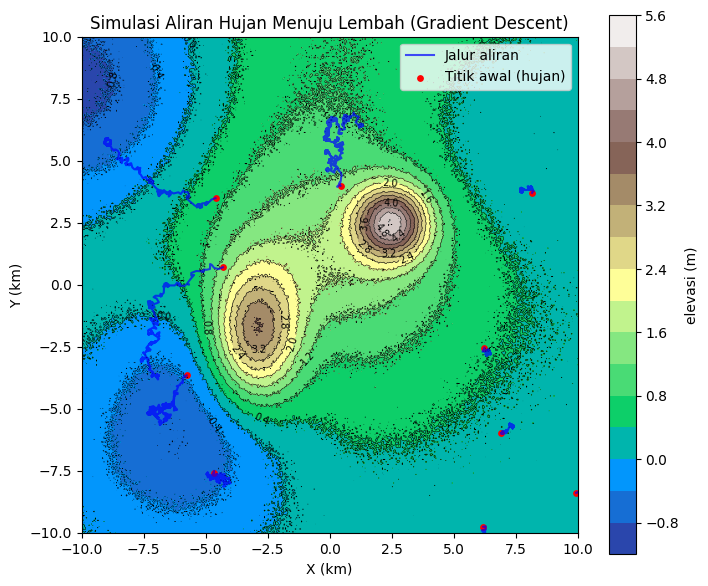

In [10]:
def simulate_flow(x0, y0, alpha=0.1, tol=1e-4, max_iter=500):
    path = [(x0, y0)]
    x_pos, y_pos = x0, y0

    for _ in range(max_iter):
        # mencari indeks grid terdekat
        ix = np.searchsorted(x, x_pos)
        iy = np.searchsorted(y, y_pos)
        ix = np.clip(ix, 1, nx - 2)
        iy = np.clip(iy, 1, ny - 2)

        # mengambil gradien di posisi sekarang
        gx = dZ_dx[iy, ix]
        gy = dZ_dy[iy, ix]

        # bergerak ke arah turunan (turun lereng)
        x_new = x_pos - alpha * gx
        y_new = y_pos - alpha * gy

        # membatasi supaya tidak keluar peta
        x_new = np.clip(x_new, x[0], x[-1])
        y_new = np.clip(y_new, y[0], y[-1])

        path.append((x_new, y_new))

        # berhenti jika sudah hampir tidak bergerak
        if np.hypot(x_new - x_pos, y_new - y_pos) < tol:
            break

        # update posisi
        x_pos, y_pos = x_new, y_new

        # jika sudah mencapai tepi peta, hentikan
        if (x_new == x[0] or x_new == x[-1] or y_new == y[0] or y_new == y[-1]):
            break

    return np.array(path)

np.random.seed(80)
n_drops = 10
paths = []
for _ in range(n_drops):
    x0 = np.random.uniform(-10, 10)
    y0 = np.random.uniform(-10, 10)
    paths.append(simulate_flow(x0, y0))

# visualisasi
fig, ax = plt.subplots(figsize=(8, 7))
levels = 18
cf = ax.contourf(X, Y, Z, levels=levels, cmap='terrain')
cs = ax.contour(X, Y, Z, levels=levels, colors='k', linewidths=0.4)
ax.clabel(cs, fmt="%.1f", fontsize=7)

for path in paths:
    ax.plot(path[:,0], path[:,1], 'b-', alpha=0.7, label='Jalur aliran' if path is paths[0] else "")
    ax.scatter(path[0,0], path[0,1], c='red', s=15, label='Titik awal (hujan)' if path is paths[0] else "")

ax.set_title("Simulasi Aliran Hujan Menuju Lembah (Gradient Descent)")
ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_aspect('equal')
plt.colorbar(cf, ax=ax, label="elevasi (m)")
ax.legend(loc='upper right')
plt.show()

**Penjelasan :**

Dari viisualisasi diatas menggambarkan proses aliran air hujan yang bergerak menuruni permukaan menuju lembah dengan pendekatan Gradient Descent.
> Titik merah menunjukkan posisi awal tetes hujan,

> Garis biru menggambarkan jalur alirannya menuju titik terendah (lembah).

Proses ini dilakukan dengan menghitung gradien dari elevasi permukaan, di mana setiap titik bergerak ke arah penurunan elevasi paling curam hingga mencapai posisi stabil. Dengan kata lain, simulasi ini ibaratkan bagaimana air hujan yang bergerak mencari jalur tercepat menuju daerah rendah (lembah). Namun, metode ini belum mempertimbangkan faktor fisik seperti hambatan permukaan, kecepatan aliran, atau arah angin yang dapat memengaruhi jalur air sebenarnya. Selain itu, hasil akhir sangat bergantung pada resolusi grid dan posisi awal titik hujan sehingga dapat berubah-ubah.

**3) kerawanan erosi ditentukan oleh kecuraman lereng, hitung skor kerawanan di tiap titik**
> hitung dengan turunan pertama kontur topologi, boleh gunakan np.gradient()

> nilai plus yang menggunakan fungsi numerik racikan sendiri untuk turunan parsialnya, yang kemudian dihitung resultannya

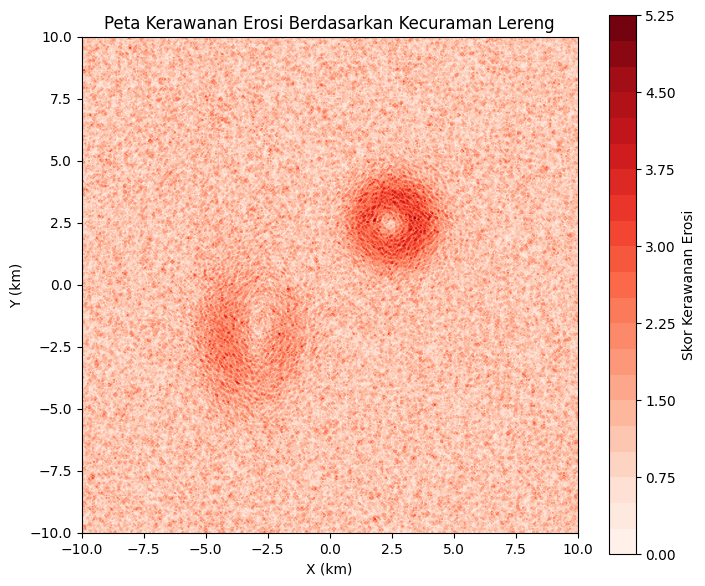

In [11]:
dx = x[1] - x[0]
dy = y[1] - y[0]

# turunan parsial manual
dZ_dx_manual = (Z[:, 2:] - Z[:, :-2]) / (2*dx)
dZ_dy_manual = (Z[2:, :] - Z[:-2, :]) / (2*dy)

# buat ukuran sama dengan Z
dZ_dx_pad = np.pad(dZ_dx_manual, ((0,0),(1,1)), mode='edge')
dZ_dy_pad = np.pad(dZ_dy_manual, ((1,1),(0,0)), mode='edge')

# resultan gradien manual
slope_manual = np.sqrt(dZ_dx_pad**2 + dZ_dy_pad**2)

fig, ax = plt.subplots(figsize=(8,7))
cf = ax.contourf(X, Y, slope_manual, cmap='Reds', levels=20)
ax.set_title("Peta Kerawanan Erosi Berdasarkan Kecuraman Lereng")
ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_aspect('equal')
plt.colorbar(cf, ax=ax, label="Skor Kerawanan Erosi")
plt.show()

**Penjelasan :**

Dari visualisasi diatas menunjukkan tingkat kerawanan erosi di suatu wilayah berdasarkan kecuraman lereng. Warna merah yang lebih pekat menandakan area dengan nilai gradien yang lebih tinggi, artinya daerah tersebut memiliki potensi erosi yang lebih besar. Semakin curam lerengnya, semakin tinggi pula kemungkinan terjadinya pergerakan tanah atau pengikisan permukaan akibat aliran air. Peta ini membantu mengidentifikasi area yang berisiko tinggi terhadap erosi dan memerlukan perhatian khusus dalam pengelolaan lahan. Namun, model ini hanya mempertimbangkan faktor kemiringan lereng tanpa memasukkan variabel lain seperti jenis tanah, vegetasi, dan curah hujan yang juga memengaruhi tingkat erosi. Selain itu, hasilnya dapat berubah-ubah jika resolusi data elevasi terlalu kasar.

**4a) jika tanah hendak diratakan, berapa banyak volume tanah yang harus dipindahkan? (dipotong dari puncak dan diurug ke lembah)**

> hitung dengan integral untuk sisi atas dan sisi bawah

In [12]:
import numpy as np

dx = x[1] - x[0]
dy = y[1] - y[0]
cell_area = dx * dy  # area setiap sel grid

def volumes_for_h(h, Z, cell_area):
    diff = Z - h
    V_cut  = np.sum(np.maximum(diff, 0.0)) * cell_area
    V_fill = np.sum(np.maximum(-diff, 0.0)) * cell_area
    return V_cut, V_fill

h_example = np.mean(Z)
Vcut_ex, Vfill_ex = volumes_for_h(h_example, Z, cell_area)
print(f"Jika diratakan ke h = {h_example:.3f}: V_cut = {Vcut_ex:.3f}, V_fill = {Vfill_ex:.3f}")

Zmin, Zmax = float(np.min(Z)), float(np.max(Z))

def f_balance(h):
    Vc, Vf = volumes_for_h(h, Z, cell_area)
    return Vc - Vf

# bisection sederhana
h_lo, h_hi = Zmin, Zmax
f_lo, f_hi = f_balance(h_lo), f_balance(h_hi)
if f_lo * f_hi > 0:
    # jarang terjadi ketika semua nilai Z sama sehingga cut-fill selalu 0
    h_balance = np.median(Z)
else:
    for _ in range(500):
        h_mid = 0.5 * (h_lo + h_hi)
        f_mid = f_balance(h_mid)
        if abs(f_mid) < 1e-6:
            break
        if f_lo * f_mid <= 0:
            h_hi, f_hi = h_mid, f_mid
        else:
            h_lo, f_lo = h_mid, f_mid
    h_balance = h_mid

Vcut_bal, Vfill_bal = volumes_for_h(h_balance, Z, cell_area)

np.set_printoptions(suppress=True)
print("\nHasil balance : ")
print(f"h_balance = {h_balance:.6f}")
print(f"V_cut(h_balance)  = {Vcut_bal:.6f}")
print(f"V_fill(h_balance) = {Vfill_bal:.6f}")
print(f"Selisih (cut - fill) = {Vcut_bal - Vfill_bal:.9f}  (harus mendekati 0)")

Jika diratakan ke h = 0.502: V_cut = 109.976, V_fill = 109.976

Hasil balance : 
h_balance = 0.501613
V_cut(h_balance)  = 109.975752
V_fill(h_balance) = 109.975753
Selisih (cut - fill) = -0.000000831  (harus mendekati 0)


**Penjelasan :**

Hasil menunjukkan bahwa perataan pada h_balance = 0.501613 menghasilkan keseimbangan dari V_cut dan V_fill = 109.976. Selisih antara keduanya tidak signifikan dan muncul karena pembulatan dan diskritisasi numerik. Oleh karena itu, volume tanah yang harus dipindahkan adalah sekitar 109.976 satuan volume.

**4b) berapa ketinggian akhir tanah yang rata tersebut?**

In [13]:
cell_area = (x[1] - x[0]) * (y[1] - y[0])

# 1) ketinggian akhir (balance) : untuk grid seragam cukup menggunakan mean
h_balance = np.mean(Z)

# 2) hitung volume cut/fill pada h_balance untuk verifikasi
def volumes_for_h(h, Z, cell_area):
    diff = Z - h
    V_cut  = np.sum(np.maximum(diff, 0.0)) * cell_area
    V_fill = np.sum(np.maximum(-diff, 0.0)) * cell_area
    return V_cut, V_fill

Vcut, Vfill = volumes_for_h(h_balance, Z, cell_area)

np.set_printoptions(suppress=True)
print(f"h_balance = {h_balance:.6f}")
print(f"V_cut  = {Vcut:.6f}")
print(f"V_fill = {Vfill:.6f}")
print(f"Selisih (V_cut - V_fill) = {Vcut - Vfill:.15f}")

h_balance = 0.501613
V_cut  = 109.975752
V_fill = 109.975752
Selisih (V_cut - V_fill) = -0.000000000000014


**Penjelasan :**

ketinggian akhir dari tanah yang rata adalah h_balance = 0.501613, dimana pada elevasi ini volume tanah potongan dan urugan seimbang sempurna dengan selilih yang mendekati nilai praktis nol.